In [11]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

import torch
from torch.utils.data import Dataset, DataLoader
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

In [12]:
class CustomDataset(Dataset):
    def __init__(self, name, phase):
        self.n_classes = 10
        if name == 'Cells': self.n_classes = 4
        if phase == 'train':
            self.n_imgs_per_class = 1000
            if name == 'Cells': self.n_imgs_per_class = 500
            self.root_path = '/home/cicconet/Development/MachineLearning/%s/Train' % name
        elif phase == 'test':
            self.n_imgs_per_class = 100
            if name == 'Cells': self.n_imgs_per_class = 200
            self.root_path = '/home/cicconet/Development/MachineLearning/%s/Test' % name
        
    def __len__(self):
        return self.n_classes*self.n_imgs_per_class

    def __getitem__(self, idx):
        folder_idx = int(idx/self.n_imgs_per_class)
        img_idx = idx-folder_idx*self.n_imgs_per_class
        img_path = self.root_path+'/{}/Image{:05d}.png'.format(folder_idx, img_idx)
        
        image = io.imread(img_path)
        image = torch.unsqueeze(torch.from_numpy(image), 0).float()/255
        sample = {'image': image, 'label': folder_idx}

        return sample

In [13]:
ds_name = 'Cells'

train_dataset = CustomDataset(ds_name, 'train')
test_dataset = CustomDataset(ds_name, 'test')
rand_i = np.random.randint(len(train_dataset), size=10)
for i in rand_i:
    item = train_dataset[i]
    img, lbl = item['image'], item['label']
    print(i, img.shape, img.dtype, img.max(), lbl)

874 torch.Size([1, 28, 28]) torch.float32 tensor(0.7569) 1
1944 torch.Size([1, 28, 28]) torch.float32 tensor(0.7098) 3
1090 torch.Size([1, 28, 28]) torch.float32 tensor(0.7961) 2
133 torch.Size([1, 28, 28]) torch.float32 tensor(0.7216) 0
76 torch.Size([1, 28, 28]) torch.float32 tensor(0.7098) 0
1619 torch.Size([1, 28, 28]) torch.float32 tensor(0.5686) 3
1748 torch.Size([1, 28, 28]) torch.float32 tensor(0.6549) 3
217 torch.Size([1, 28, 28]) torch.float32 tensor(0.6039) 0
1056 torch.Size([1, 28, 28]) torch.float32 tensor(0.5176) 2
1336 torch.Size([1, 28, 28]) torch.float32 tensor(0.7216) 2


In [14]:
train_loader = DataLoader(train_dataset, batch_size=4,  shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4,  shuffle=True, num_workers=4)

0 0.5921569 tensor(1)
1 0.73333335 tensor(3)
2 0.73333335 tensor(2)
3 0.61960787 tensor(3)
4 0.53333336 tensor(3)


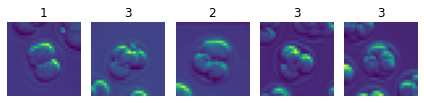

In [15]:
fig = plt.figure()
for idx, batch in enumerate(train_loader):
    imgs, lbls = batch['image'], batch['label']
    print(idx, imgs[0].numpy().squeeze().max(), lbls[0])
    ax = plt.subplot(1,5,idx+1)
    ax.imshow(imgs[0].numpy().squeeze())
    ax.axis('off')
    plt.tight_layout()
    plt.title(batch['label'][0].item())
    if idx == 4:
        break

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # n chan in, n chan out, kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
data_iter = iter(train_loader)
batch = data_iter.next()

imgs, lbls = batch['image'], batch['label']
print(imgs.dtype, imgs.shape, lbls)

net = Net()
print(net(imgs).shape)

torch.float32 torch.Size([4, 1, 28, 28]) tensor([3, 0, 3, 1])
torch.Size([4, 10])


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net.to(device)
criterion.to(device)

cuda:0


CrossEntropyLoss()

In [19]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('/home/cicconet/Downloads/TensorBoard')

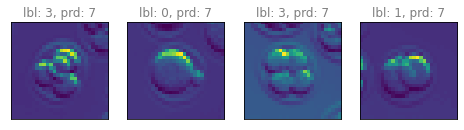

In [20]:
def plot_imgs_lbls_prds(imgs, lbls, prds):
    fig = plt.figure(figsize=(8, 2))
    for i in range(len(lbls)):
        ax = fig.add_subplot(1, len(lbls), i+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(imgs[i]))
        ax.set_title('lbl: %d, prd: %d' % (lbls[i], prds[i]),c='gray')
    return fig

imgs = imgs.to(device)
lbls = lbls.to(device)
prds = net(imgs)
_, imx = torch.max(prds,1)

# print(lbls.detach().numpy().dtype, imx.cpu().numpy().dtype)
f = plot_imgs_lbls_prds(imgs.cpu().numpy(), lbls.cpu().numpy(), imx.cpu().numpy())
# f.show()


In [21]:
running_loss = 0.0
for epoch in range(50):
    for i, batch in enumerate(train_loader):
        imgs, lbls = batch['image'].to(device), batch['label'].to(device)

        optimizer.zero_grad()

        pred = net(imgs)
        loss = criterion(pred, lbls)
        loss.backward()
        optimizer.step()

        running_loss = 0.5*running_loss+0.5*loss.item()
        writer.add_scalar('training_loss', running_loss, epoch*len(train_loader)+i)
        if i % 500 == 499:
            _, imx = torch.max(pred,1)
            writer.add_figure('imgs_lbls_prds',\
                              plot_imgs_lbls_prds(imgs.cpu().numpy(), lbls.cpu().numpy(), imx.cpu().numpy()),\
                              global_step=epoch*len(train_loader)+i)
            print('epoch', epoch+1, 'batch', i+1, 'loss', running_loss)
writer.close()

epoch 1 batch 500 loss 1.440409817072247
epoch 2 batch 500 loss 1.39254787363532
epoch 3 batch 500 loss 1.3657173246914658
epoch 4 batch 500 loss 1.392568871388631
epoch 5 batch 500 loss 1.36146985278509
epoch 6 batch 500 loss 1.4108831144673488
epoch 7 batch 500 loss 1.403914253669659
epoch 8 batch 500 loss 1.4227412599494378
epoch 9 batch 500 loss 1.3660589612510843
epoch 10 batch 500 loss 1.3884318419409403
epoch 11 batch 500 loss 1.4046321921567027
epoch 12 batch 500 loss 1.3435092207595714
epoch 13 batch 500 loss 1.349317049116056
epoch 14 batch 500 loss 1.3634181556091365
epoch 15 batch 500 loss 1.4017378637522275
epoch 16 batch 500 loss 1.3038161246126898
epoch 17 batch 500 loss 1.370147979410893
epoch 18 batch 500 loss 1.188804516834813
epoch 19 batch 500 loss 1.1932846832172201
epoch 20 batch 500 loss 0.9380057297432789
epoch 21 batch 500 loss 0.8994494891228293
epoch 22 batch 500 loss 0.5943065141734942
epoch 23 batch 500 loss 0.8068018053723554
epoch 24 batch 500 loss 0.7328

In [22]:
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        imgs, lbls = batch['image'].to(device), batch['label'].to(device)
        pred = net(imgs)
        mx, imx = torch.max(pred,1)
        total += len(lbls)
        correct += (imx == lbls).sum().item()

print('test accuracy', correct / total)

test accuracy 0.935
